# Central bank communication & information overload: an empirical analysis of fed speeches and market reactions

**Author:** Anaïs Augé & Alexandre Nonnenmacher

**Course:** Machine learning for Portfolio Management and Trading

**Date:** November 14, 2025


### Setup and dependencies

This notebook requires several Python packages. The following cells ensures all necessary libraries are installed and imported.

In [1]:
import sys
import subprocess
import pkg_resources
import importlib

# Mapping to handle pip-name vs import-name differences
PACKAGE_MAP = {
    "sentence-transformers": "sentence_transformers",
    "beautifulsoup4": "bs4",
    "sklearn": "sklearn",
    "statsmodels": "statsmodels",
    "umap-learn": "umap",
}

# Required pip package names
REQUIRED_PACKAGES = [
    "pandas", "numpy", "matplotlib", "seaborn", "nltk", "scikit-learn",
    "sentence-transformers", "transformers", "torch", "torchvision", "torchaudio",
    "yfinance", "selenium", "webdriver-manager", "requests", "beautifulsoup4",
    "umap-learn", "statsmodels"
]

def pip_install(package):
    """Install a package via pip."""
    print(f"→ Installing {package} ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    print(f"✓ Installed {package}\n")

def is_installed(package):
    """Check if a package (import name) is installed."""
    try:
        importlib.import_module(package)
        return True
    except ImportError:
        return False

print("Checking required Python packages...\n")

missing = []

for pip_name in REQUIRED_PACKAGES:
    import_name = PACKAGE_MAP.get(pip_name, pip_name)

    if not is_installed(import_name):
        print(f"✗ {pip_name} NOT installed")
        missing.append(pip_name)
    else:
        version = pkg_resources.get_distribution(pip_name.replace("-", "_")).version \
            if pip_name.replace("-", "_") in [pkg.key for pkg in pkg_resources.working_set] else "?"
        print(f"✓ {pip_name} already installed (v{version})")

# Install missing packages
if missing:
    print("\nInstalling missing packages:\n")
    for pkg in missing:
        try:
            pip_install(pkg)
        except Exception as e:
            print(f"Failed to install {pkg}: {e}")

    print("Installation complete.\n")
else:
    print("\nAll packages are already installed.\n")

# NLTK stopwords
try:
    from nltk.corpus import stopwords
    stopwords.words('english')
    print("NLTK 'stopwords' are available.")
except LookupError:
    print("NLTK 'stopwords' not found. Downloading...")
    import nltk
    import ssl
    try:
        # Create an unverified SSL context to bypass certificate errors
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context
    
    nltk.download('stopwords', quiet=True)
    print("'stopwords' downloaded successfully.")

Checking required Python packages...



/var/folders/f8/tpyqz0q51mb_8r_lpkqb9wc80000gn/T/ipykernel_5830/2389227593.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✓ pandas already installed (v2.3.3)
✓ numpy already installed (v2.3.4)
✓ matplotlib already installed (v3.10.7)
✓ seaborn already installed (v0.13.2)
✓ nltk already installed (v3.9.2)
✗ scikit-learn NOT installed


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ sentence-transformers already installed (v?)
✓ transformers already installed (v4.57.1)
✓ torch already installed (v2.9.1)
✓ torchvision already installed (v0.24.1)
✓ torchaudio already installed (v2.9.1)
✓ yfinance already installed (v0.2.66)
✓ selenium already installed (v4.38.0)
✗ webdriver-manager NOT installed
✓ requests already installed (v2.32.5)
✓ beautifulsoup4 already installed (v4.14.2)
✓ umap-learn already installed (v?)
✓ statsmodels already installed (v0.14.5)

Installing missing packages:

→ Installing scikit-learn ...
✓ Installed scikit-learn

→ Installing webdriver-manager ...



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


✓ Installed webdriver-manager

Installation complete.

NLTK 'stopwords' are available.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [2]:
# Library imports: all necessary libraries for the project are imported here.

# Core data science & numerics 
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Data acquisition & web scraping 
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from selenium import webdriver 

# Natural Language Processing (NLP) 
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Machine learning & statistics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import statsmodels.api as sm
import umap 

# System & utilities 
# (No other system imports needed here as they are in Cell 1)

# Set plot style for consistency 
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


## I. Introduction

#### Contextual Background
Central bank communication has evolved into a primary tool for monetary policy. Speeches, press conferences, and testimonies from Federal Reserve (Fed) officials are closely monitored by financial markets to anticipate future decisions on interest rates, inflation, and economic growth. However, the increasing frequency of these public statements raises a critical question: the issue of **information overload**. Could an excess of communication, or communication that is overly redundant, paradoxically reduce the clarity of the message and increase market volatility instead of dampening it? While existing research has often focused on the impact of sentiment or specific topics, the effect of communication *intensity* and *saturation* remains an open and compelling question.

#### Project Contributions
This project addresses this gap by proposing a quantitative methodology to measure the intensity of Fed communication. Our contributions are threefold:
1.  **Construction of a Communication Saturation Index (CSI):** We develop an index based on sentence embeddings (via SBERT) to quantify the redundancy of messages over short horizons, both within the same week and in relation to preceding weeks.
2.  **Development of a Communication Intensity Index (CII):** We aggregate multiple dimensions of communication, including frequency, length, speaker diversity, tone (via FinBERT), and redundancy (CSI), into a single synthetic indicator, the *Communication Intensity Index*.
3.  **Empirical Impact Analysis:** We investigate the (potentially non-linear) impact of the CII on financial market reactions (SPX, VIX, TNX, DXY) over 1-, 2-, and 3-day horizons.

#### Summary of Main Empirical Results
Our analysis reveals statistically significant but modest correlations. Notably, an increase in communication intensity (CII) is associated with slightly lower SPX returns and a mild rise in the VIX and DXY over a 1- to 3-day horizon. Analysis by semantic themes does not show a clearly differentiated market reaction, suggesting that it is the overall intensity, rather than the specific topic, that influences markets. While not strongly predictive on their own, these findings indicate that the *manner* in which the Fed communicates (its frequency and repetitiveness) has a measurable, albeit subtle, impact on market behavior.

#### Literature and Resource Citations
-   **Related Academic Papers:** 
    -   Hansen, S., & McMahon, M. (2016). *Shocking Language: Understanding the Macroeconomic Effects of Central Bank Communication*. Journal of International Economics.
    -   Ehrmann, M., & Talmi, J. (2020). *Starting from a blank page? Semantic similarity in central bank communication and market volatility*.
    -   Bulíř, A., Čihák, M., & Jansen, D. J. (2014). Does the Clarity of Inflation Reports Affect Volatility in Financial Markets? 
    -   Crayton, A. (2018). Central Bank Communication and the Yield Curve: A Semi-Automatic Approach using Non-Negative Matrix Factorization. 
    -   Ehrmann, M., & Talmi, J. (2020). Starting from a blank page? Semantic similarity in central bank communication and market volatility. 
    -   Hansen, S., McMahon, M., & Tong, M. (2019). The long-run information effect of central bank communication. 
    -   Silva, T. C., Moriya, K., & Veyrune, R. M. (2025). From Text to Quantified Insights: A Large-Scale LLM Analysis of Central Bank Communication. 
    -   Tutino, A. (2016). Central Bank Communication Must Overcome the Public's Limited Attention Span. Dallas Fed Economic Letter, 11(6).
-   **Software and Resources:** 
    -   Data was scraped from the [Federal Reserve website](https://www.federalreserve.gov/newsevents/speeches.htm).
    -   Market data was sourced using the `yfinance` library.
    -   NLP analysis relied on `sentence-transformers`, `transformers` (Hugging Face), and `scikit-learn`.

## II. Dataset Overview

#### 1. Data Sources and Composition
The data used for this study are composed of two primary sources:

-   **Federal Reserve Speeches:** The textual data consists of a corpus of public speeches from members of the Federal Reserve Board of Governors, scraped from the Fed's official website. The dataset, `fed_speeches.csv`, covers the period from 1st November of 2011 to 1st November of 2025 and includes metadata such as the date, speaker, title, and word count. After a cleaning process to remove duplicates and speeches with fewer than 20 words, the corpus is prepared for analysis.
-   **Financial Market Data:** To measure market reactions, daily data for four key indices were downloaded using the `yfinance` library:
    -   **SPX (^GSPC):** S&P 500 index, representing the broad equity market.
    -   **VIX (^VIX):** CBOE Volatility Index, often termed the "fear index."
    -   **TNX (^TNX):** 10-Year U.S. Treasury yield, a benchmark for interest rates.
    -   **DXY (DX-Y.NYB):** U.S. Dollar Index, measuring its value against a basket of foreign currencies.

This section details the acquisition and key characteristics of both datasets to provide a comprehensive foundation for our analysis.

#### 2. Data Acquisition

To ensure full reproducibility, all data is acquired dynamically through the code in the following cells.

##### 2.1. Federal Reserve Speeches (Web Scraping)

The following cells will dynamically create and execute a Python script (scraping.py) to scrape the Federal Reserve speeches. This process populates the fed_speeches.csv file, which contains the full text and metadata for each speech.

Note: The scraping process only needs to be run once. If the fed_speeches.csv file already exists in your environment, you can skip executing the next two cells.

In [3]:
%%writefile scraping.py

from __future__ import annotations

import csv, os, re, time, random
from datetime import datetime
from pathlib import Path
from urllib.parse import urljoin

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

import requests
from bs4 import BeautifulSoup, Tag
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# --- DATES TO CONFIGURE MANUALLY ---
# Enter the desired start date here (Year, Month, Day)
START_DATE = datetime(2011, 11, 1) 
# Enter the desired end date here
END_DATE = datetime(2025, 11, 1)
# --- END OF CONFIGURATION ---


BASE = "https://www.federalreserve.gov"
YEAR_URL = BASE + "/newsevents/speech/{year}-speeches.htm"

OUT_DIR = Path.cwd()
FULL_CSV  = OUT_DIR / "fed_speeches.csv"

# If a speech has fewer than 150 words, it will be reprocessed on the next run
REPROCESS_IF_WC_LT = 150

SPEECH_URL_RE = re.compile(r"/newsevents/speech/[a-z0-9-]*\d{8}[a-z]?\.htm$", re.I)
DATE_MMDDYYYY = re.compile(r"\b\d{1,2}/\d{1,2}/\d{4}\b")

def make_driver():
    opts = Options()
    opts.add_argument("--headless=new")     
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    opts.add_argument("--user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126 Safari/537.36")
    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service, options=opts)

def write_rows(path: Path, rows, header):
    if not rows: return
    file_exists = path.exists()
    with open(path, "a", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=header)
        if not file_exists:
            w.writeheader()
        w.writerows(rows)

def parse_date_from_text(txt: str):
    m = DATE_MMDDYYYY.search(txt or "")
    if not m: return ""
    try:
        dt = datetime.strptime(m.group(0), "%m/%d/%Y")
        return dt.strftime("%Y-%m-%d")
    except:
        return ""

def date_from_url(href: str):
    m = re.search(r'/(\d{8})[a-z]?\.htm$', href or "")
    if not m: return ""
    s = m.group(1)
    try:
        dt = datetime(int(s[:4]), int(s[4:6]), int(s[6:8]))
        return dt.strftime("%Y-%m-%d")
    except:
        return ""

def extract_speaker_from_block(text_block: str):
    if not text_block: return ""
    lines = [ln.strip() for ln in text_block.splitlines() if ln.strip()]
    for ln in lines:
        lo = ln.lower()
        if lo.startswith("by "): return ln[3:].strip()
        if "speaker:" in lo:     return ln.split(":",1)[1].strip()
        if any(k in ln for k in ["Chair", "Governor", "President", "Vice Chair"]):
            return ln.strip()
    return ""

def nearest_container(a_el):
    XPATHS = [
        "./ancestor::li[1]",
        "./ancestor::div[contains(@class,'row')][1]",
        "./ancestor::article[1]",
        "./parent::div"
    ]
    for xp in XPATHS:
        try:
            c = a_el.find_element(By.XPATH, xp)
            if c and c.text.strip():
                return c
        except:
            pass
    return a_el

def make_session():
    s = requests.Session()
    s.headers.update({
        "User-Agent": ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                       "AppleWebKit/537.36 (KHTML, like Gecko) "
                       "Chrome/126.0 Safari/537.36")
    })
    retry = Retry(total=5, backoff_factor=0.5,
                  status_forcelist=(429,500,502,503,504),
                  allowed_methods=("GET",))
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://",  HTTPAdapter(max_retries=retry))
    return s

WS_RE   = re.compile(r"\s+")
WORD_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ0-9’']+")
FOOTNOTE_ANCHOR = re.compile(r"^fn\d+$", re.I)

def clean_text(t:str) -> str:
    return WS_RE.sub(" ", t).strip()

def count_words(t:str) -> int:
    return len(WORD_RE.findall(t))

def _good_para_text(t:str) -> bool:
    if not t: return False
    low = t.lower()
    if "watch live" in low or low.startswith("share"): return False
    if t == "PDF": return False
    return count_words(t) >= 25

def _score_candidate(div: Tag) -> int:
    score = 0
    for p in div.find_all("p"):
        if p.find("a", attrs={"name": FOOTNOTE_ANCHOR}): 
            continue
        txt = p.get_text(" ", strip=True)
        if _good_para_text(txt):
            score += 1
    return score

def _pick_main_body(root: Tag) -> Tag:
    candidates = []
    selectors = [
        "#content div.col-xs-12.col-sm-8.col-md-8",
        "#content div.col-sm-8.col-md-8",
        "#content div.col-sm-8",
        "#content article",
        "div.col-xs-12.col-sm-8.col-md-8",
        "div.col-sm-8.col-md-8",
        "div.col-sm-8",
        "article",
    ]
    seen = set()
    for sel in selectors:
        for div in root.select(sel):
            if id(div) in seen: 
                continue
            seen.add(id(div))
            candidates.append(div)
    return max(candidates, key=_score_candidate) if candidates else root

def extract_transcript(html: str) -> str:
    soup = BeautifulSoup(html, "html.parser")
    root = soup.select_one("#content") or soup
    body = _pick_main_body(root)
    stop = root.select_one("#lastUpdate")

    parts = []
    for p in body.find_all("p", recursive=True):
        if stop and (p is stop or stop in p.parents):
            break
        if p.find("a", attrs={"name": FOOTNOTE_ANCHOR}):
            continue
        txt = p.get_text(" ", strip=True)
        if _good_para_text(txt):
            parts.append(txt)

    if not parts:  
        for p in body.find_all("p", recursive=True):
            if stop and (p is stop or stop in p.parents):
                break
            if p.find("a", attrs={"name": FOOTNOTE_ANCHOR}):
                continue
            txt = p.get_text(" ", strip=True)
            if count_words(txt) >= 5:
                parts.append(txt)

    text = " ".join(parts)
    text = re.sub(r"\s*\[\d+\]\s*", " ", text)
    text = re.sub(r"\s*\(\d+\)\s*", " ", text)
    return clean_text(text)

def scrape_and_process_speeches():
    """
    Scrapes Federal Reserve speeches for a given period and saves all data
    directly into a single CSV file.
    """
    print(f"→ Starting scraper for the period from {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
    print(f"→ Output file will be: {FULL_CSV}")

    # Resume logic: read already scraped URLs to avoid reprocessing them
    done_urls = set()
    if FULL_CSV.exists():
        with open(FULL_CSV, "r", encoding="utf-8") as f:
            for r in csv.DictReader(f):
                url = (r.get("url") or "").strip()
                if not url: continue
                try:
                    wc = int(r.get("word_count") or 0)
                    if wc >= REPROCESS_IF_WC_LT:
                        done_urls.add(url)
                except ValueError:
                    continue
    print(f"Found {len(done_urls)} already processed and valid speeches.")

    driver = make_driver()
    session = make_session()
    
    header = ["date", "title", "speaker", "url", "word_count", "text"]
    batch, total_new_speeches = [], 0

    # Iterate through the years, from most recent to oldest
    for year in range(END_DATE.year, START_DATE.year - 1, -1):
        year_url = YEAR_URL.format(year=year)
        print(f"\n[Indexing Year {year}] {year_url}")
        
        try:
            driver.get(year_url)
            WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a")))
            time.sleep(0.5)
        except Exception as e:
            print(f"  [WARNING] Could not load the page for year {year}: {e}")
            continue

        anchors = driver.find_elements(By.CSS_SELECTOR, "a[href^='/newsevents/speech/'][href$='.htm']")
        
        for a in anchors:
            try:
                href = a.get_attribute("href") or ""
                if not SPEECH_URL_RE.search(href):
                    continue

                full_url = urljoin(BASE, href)
                if full_url in done_urls:
                    continue
                
                # --- Date validation ---
                cont_for_date = nearest_container(a)
                date_str = parse_date_from_text(cont_for_date.text) or date_from_url(href)
                if not date_str:
                    continue
                
                speech_date = datetime.strptime(date_str, "%Y-%m-%d")
                if not (START_DATE <= speech_date <= END_DATE):
                    continue
                
                # --- If the URL is new and within the date range, process it ---
                print(f"  > Processing: {full_url}")
                
                resp = session.get(full_url, timeout=30)
                resp.raise_for_status()
                
                text = extract_transcript(resp.text)
                wc = count_words(text)
                
                ctx_text = cont_for_date.text if cont_for_date else ""

                row = {
                    "date": date_str,
                    "title": (a.text or a.get_attribute("title") or "").strip(),
                    "speaker": extract_speaker_from_block(ctx_text),
                    "url": full_url,
                    "word_count": wc,
                    "text": text
                }
                
                batch.append(row)
                total_new_speeches += 1
                done_urls.add(full_url) # Add to set to avoid duplicates within the same session

                # Write in batches to avoid keeping everything in memory
                if len(batch) >= 20:
                    write_rows(FULL_CSV, batch, header=header)
                    print(f"    ...batch of {len(batch)} speeches written to CSV (new total: {total_new_speeches})")
                    batch = []
                
                time.sleep(random.uniform(0.1, 0.2))

            except Exception as e:
                # Ignore errors on a single speech to avoid halting the entire process
                # print(f"  [WARNING] Error on speech {href}: {e}")
                continue
    
    # Write the last batch if any remains
    if batch:
        write_rows(FULL_CSV, batch, header=header)
        print(f"    ...final batch of {len(batch)} speeches written to CSV (new total: {total_new_speeches})")

    driver.quit()
    print(f"\nScraping complete. {total_new_speeches} new speeches were added.")


def main():
    # Optional: to ensure you start from scratch, uncomment the lines below to delete the old file
    # if FULL_CSV.exists():
    #     print(f"Deleting old file: {FULL_CSV}")
    #     os.remove(FULL_CSV)

    scrape_and_process_speeches()

    print(f"\nFinal CSV file created/updated at: {FULL_CSV}")

if __name__ == "__main__":
    main()

Writing scraping.py


In [4]:
# Execute the scraping script
# Note: This may take several minutes.
!python scraping.py

→ Starting scraper for the period from 2011-11-01 to 2025-11-01
→ Output file will be: /Users/anaisauge/Desktop/projet /fed_speeches.csv
Found 0 already processed and valid speeches.

[Indexing Year 2025] https://www.federalreserve.gov/newsevents/speech/2025-speeches.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/bowman20251030a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/barr20251023a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/barr20251022b.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/barr20251022a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/waller20251021a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/bowman20251016a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/waller20251016a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/barr20251016a.htm
  > Processing: https://www.federalreserve.gov/newsevent

In [11]:
# Load speeches 
speeches = pd.read_csv("fed_speeches.csv", parse_dates=["date"]).sort_values("date")

# Basic hygiene
speeches = speeches.drop_duplicates(subset=["url", "date", "speaker"])
speeches["word_count"] = pd.to_numeric(speeches.get("word_count"), errors="coerce")
speeches = speeches.dropna(subset=["text", "date", "speaker"])
speeches = speeches[speeches["text"].str.len() > 30]
speeches = speeches[speeches["word_count"] > 20].reset_index(drop=True)

# Time keys
speeches["year"]  = speeches["date"].dt.year
speeches["month"] = speeches["date"].dt.to_period("M").dt.to_timestamp("M")
speeches["week"]  = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

##### 2.2. Financial Market Data (API Download)

Once the speech corpus is created, we download the corresponding daily market data from Yahoo Finance using the yfinance library.
The time period for this data is dynamically determined by the start and end dates of our scraped speeches corpus, ensuring chronological consistency and data availability for our entire sample.

In [8]:
# Define tickers
tickers = {"SPX": "^GSPC", "VIX": "^VIX", "TNX": "^TNX", "DXY": "DX-Y.NYB"}

# Define the date range for market data based on the speeches' dates
start_date = speeches["date"].min() - pd.Timedelta(days=7)
end_date   = speeches["date"].max() + pd.Timedelta(days=7)

print(f"Downloading market data from {start_date.date()} to {end_date.date()}...")

# Load daily closing prices
market_daily = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
market_daily.columns = list(tickers.keys())
market_daily = market_daily.reset_index()
market_daily.rename(columns={'Date': 'date'}, inplace=True)
market_daily['date'] = pd.to_datetime(market_daily['date'])

print("Market data downloaded successfully.")
market_daily.head()

/var/folders/f8/tpyqz0q51mb_8r_lpkqb9wc80000gn/T/ipykernel_5830/1212496775.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_daily = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed

Market data downloaded successfully.


,date,SPX,VIX,TNX,DXY
0,2011-10-28,75.089996,1285.089966,2.306,24.530001
1,2011-10-31,76.169998,1253.300049,2.175,29.959999
2,2011-11-01,77.260002,1218.280029,2.001,34.770000
3,2011-11-02,77.010002,1237.900024,2.006,32.740002
4,2011-11-03,76.669998,1261.150024,2.066,30.500000


#### 3. Descriptive Statistics

##### 3.1. The Speeches Corpus

A descriptive exploration of the speeches corpus helps us understand the dynamics of Fed communication. We analyze who speaks, when, how often, and at what pace.

Yearly summary:
       n_speeches       avg_wc  n_speakers
year                                     
2021          68  2322.838235           8
2022          45  2188.088889           9
2023          95  2090.768421           8
2024         104  2498.903846           8
2025         104  2302.451923          12

Top speakers:
                                 n_speeches       avg_wc
speaker                                                
Governor Michelle W. Bowman            116  2503.068966
Governor Lael Brainard                  99  2710.101010
Governor Christopher J. Waller          70  2402.842857
Chair Jerome H. Powell                  61  1458.704918
Governor Jerome H. Powell               50  2351.700000
Vice Chairman Stanley Fischer           45  2913.644444
Chair Janet L. Yellen                   44  2737.136364
Governor Lisa D. Cook                   42  2050.095238
Vice Chair Richard H. Clarida           39  2331.923077
Chairman Ben S. Bernanke                36  2679.611111


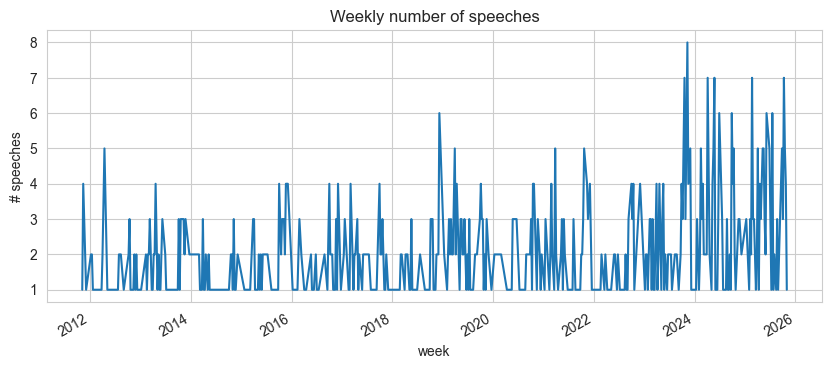

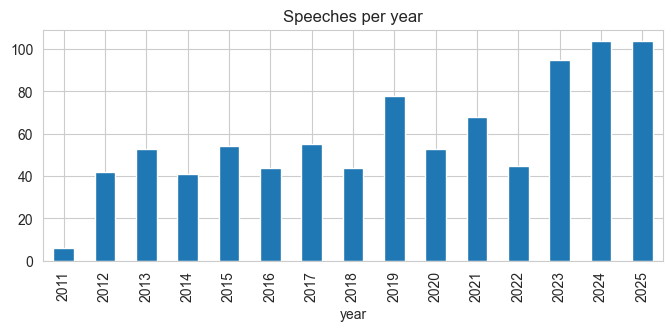


Correlation (# speeches vs avg length): -0.02


In [13]:
# Basic yearly and speaker stats
by_year = speeches.groupby("year").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)
by_speaker = speeches.groupby("speaker").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean")
).sort_values("n_speeches", ascending=False).head(10)

print("Yearly summary:\n", by_year.tail())
print("\nTop speakers:\n", by_speaker)

# Weekly and monthly cadence
weekly = speeches.groupby("week").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)

# Plots
weekly["n_speeches"].plot(figsize=(10,4), title="Weekly number of speeches", ylabel="# speeches")
plt.show()

by_year["n_speeches"].plot(kind="bar", figsize=(8,3), title="Speeches per year")
plt.show()

# Correlation check
corr = weekly["n_speeches"].corr(weekly["avg_wc"])
print(f"\nCorrelation (# speeches vs avg length): {corr:.2f}")

**Key Observations:**
- The number of speeches per year has increased notably, motivating our investigation into information overload.
- Communication is concentrated among a few key governors.
- The correlation between the number of weekly speeches and their average length is very weak and slightly negative (–0.03). This suggests that weeks with intense communication do not feature longer speeches; instead, messages might be shorter and more repetitive.

Preliminary Lexical Analysis:

Before diving into complex semantic modeling, a simple lexical analysis helps reveal the dominant words and their evolution over time. This provides an initial glimpse into the Fed's shifting focus.

In [14]:
nltk.download('stopwords')

speeches = pd.read_csv("fed_speeches.csv", parse_dates=["date"]).sort_values("date")
speeches = speeches.dropna(subset=["text"]).copy()
speeches = speeches[speeches["text"].str.len() > 30].reset_index(drop=True)

STOPWORDS = set(stopwords.words("english"))                                     # Convert everything to lowercase (case-insensitive analysis)
def clean_text(txt):
    txt = str(txt).lower()
    txt = re.sub(r"[^a-z\s]", " ", txt)                                         # Remove punctuation, numbers, and symbols
    return [w for w in txt.split() if w not in STOPWORDS and len(w) > 2]        # Split text into individual words (“tokens”), remove useless common words (“the”, “and”, “of”…) and remove ultra-short tokens like “a”, “us”, “it”

speeches["tokens"] = speeches["text"].apply(clean_text)
speeches["year"] = speeches["date"].dt.year

# Top frequent words per year : here, we group all speeches from the same year, merge all their tokens and find the most common words 
def top_words_by_year(df, n=10):
    return (
        df.groupby("year")["tokens"]
          .apply(lambda x: Counter([w for tokens in x for w in tokens]).most_common(n))
    )

# Flatten yearly top words to a tidy DataFrame
records = []
top_words = top_words_by_year(speeches, n=15)
for year, lst in top_words.items():
    for word, count in lst:
        records.append((int(year), word, int(count)))

df_top = pd.DataFrame(records, columns=["year", "word", "count"]).sort_values(["year","count"], ascending=[True, False]) 

# Normalize by total tokens per year (so years are comparable)
year_totals = (
    speeches.groupby("year")["tokens"]
            .apply(lambda toks: sum(len(t) for t in toks))
            .rename("year_token_total")
)
df_top = df_top.merge(year_totals, on="year", how="left")
df_top["freq_pct"] = 100 * df_top["count"] / df_top["year_token_total"]

# Quick global word frequency: this merges all speeches together, giving the 30 most frequent words in the full dataset:
all_words = [w for tokens in speeches["tokens"] for w in tokens]
freq = Counter(all_words).most_common(30)
pd.DataFrame(freq, columns=["word", "count"]).head(10)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1028)>


,word,count
0,financial,11527
1,policy,10485
2,inflation,10119
3,banks,8842
4,federal,8218
5,market,7063
6,rate,6913
7,bank,6573
8,percent,6363
9,reserve,6049


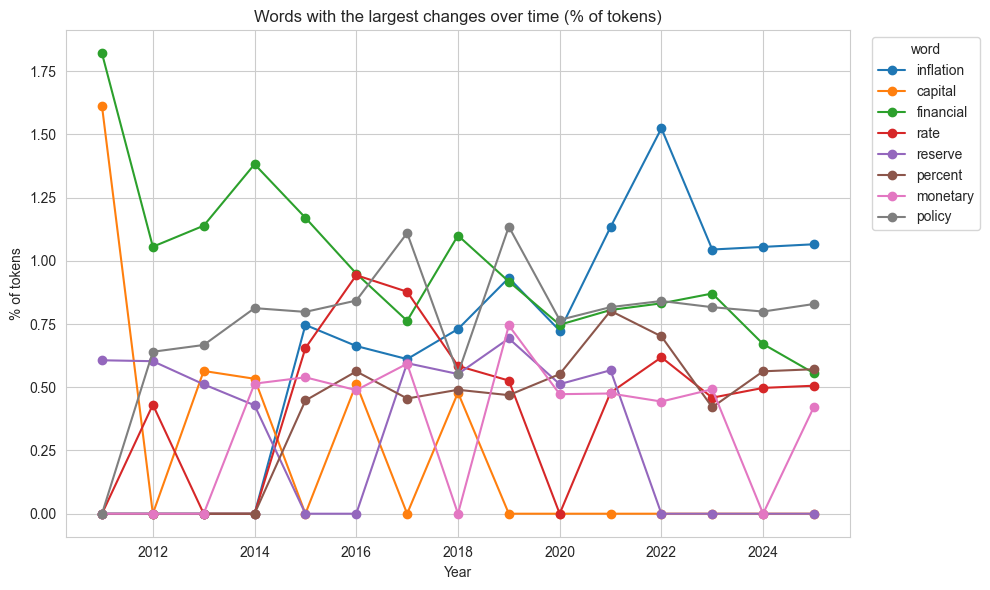

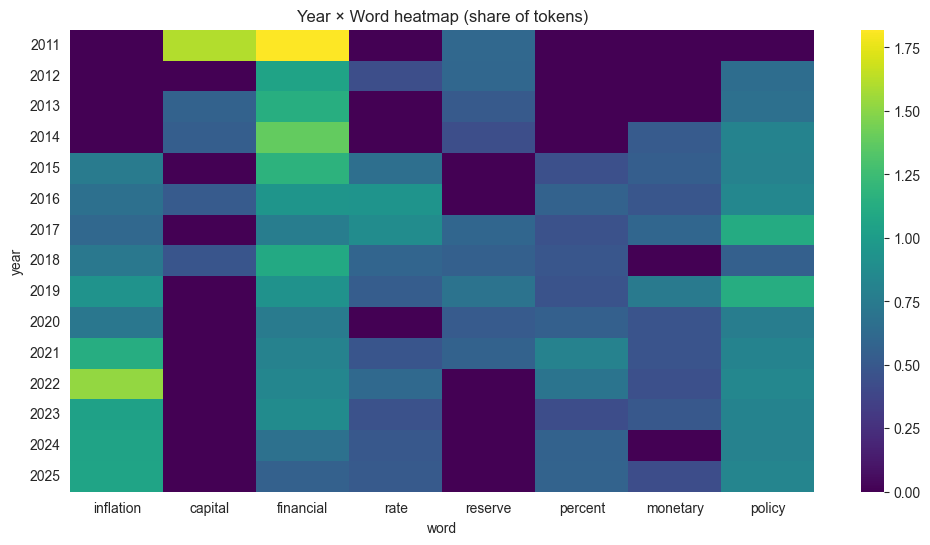

In [15]:
# Pivot to year x word matrix of % frequencies
mat = df_top.pivot_table(index="year", columns="word", values="freq_pct", fill_value=0)

# Pick words with largest variance over years
top_var_words = mat.var().sort_values(ascending=False).head(8).index.tolist()

mat[top_var_words].plot(figsize=(10,6), marker="o")
plt.title("Words with the largest changes over time (% of tokens)")
plt.xlabel("Year"); plt.ylabel("% of tokens"); plt.legend(title="word", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(mat[top_var_words], cmap="viridis")
plt.title("Year × Word heatmap (share of tokens)")
plt.xlabel("word"); plt.ylabel("year")
plt.show()

**Key Observations:**
- Words like "inflation," "policy," and "labor" exhibit significant temporal variance, with "inflation" becoming particularly dominant post-2021, aligning with the macroeconomic context.
- This preliminary analysis highlights the changing focus of the Fed's narrative over the years.

##### 3.2. Financial Market Dynamics

An overview of the market data provides context for the period under study. The following visualizations show the evolution and relationships of the key indices.

# A MODIFIER ??

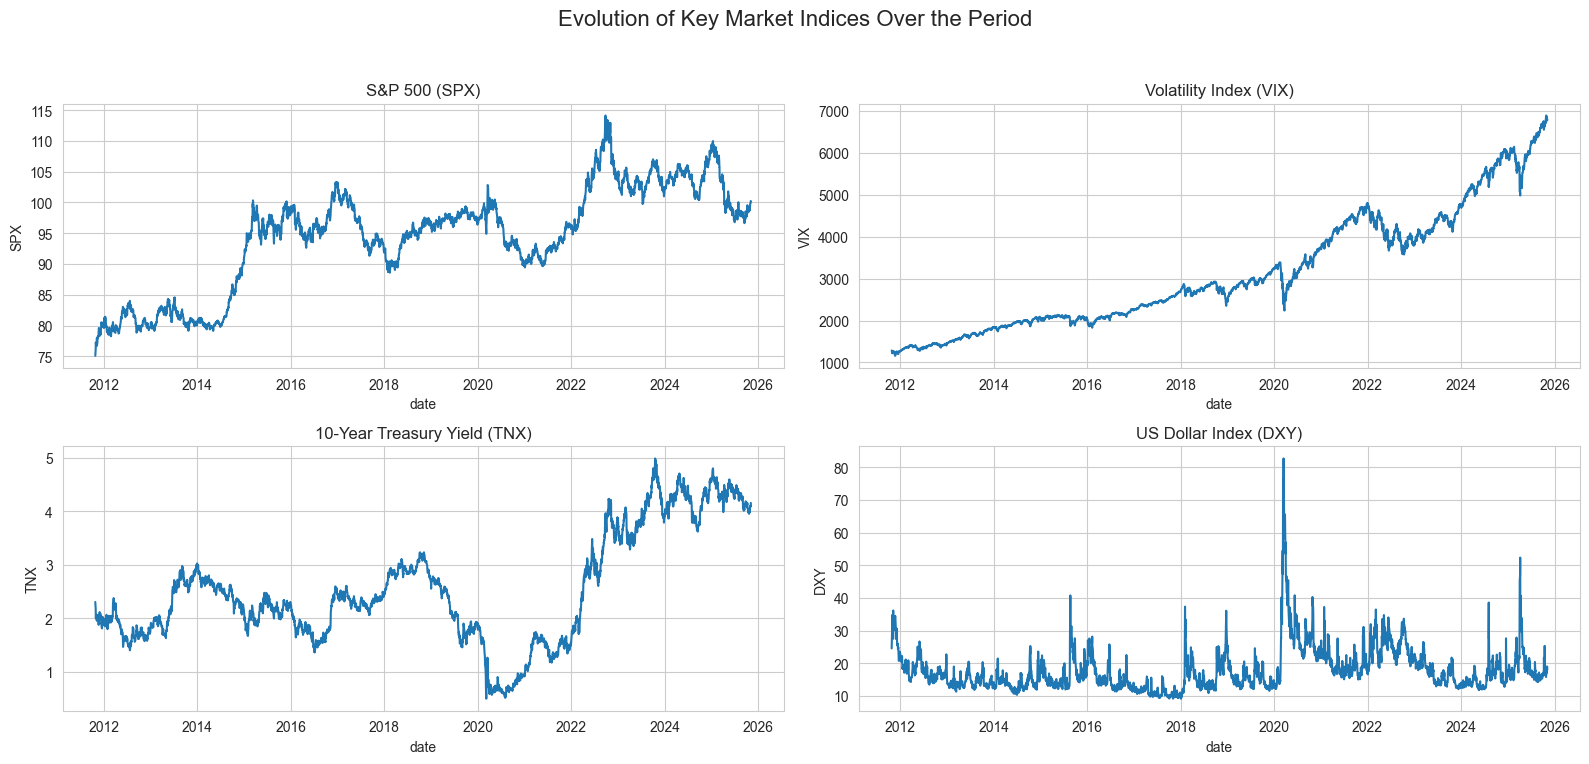

/var/folders/f8/tpyqz0q51mb_8r_lpkqb9wc80000gn/T/ipykernel_5830/1095093446.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_returns = market_daily[list(tickers.keys())].pct_change().dropna()


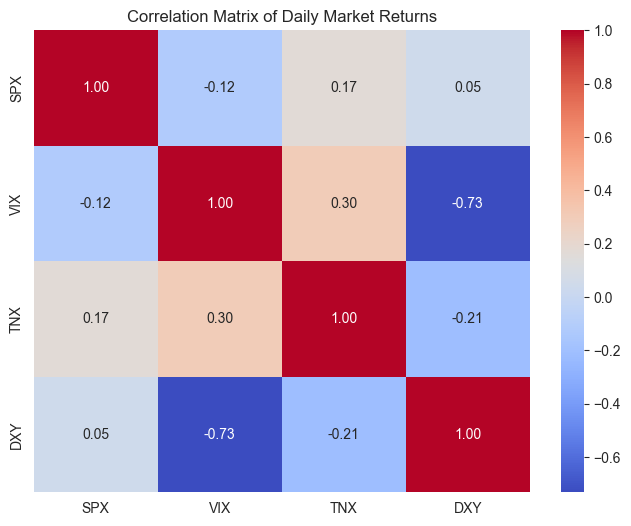

In [16]:
# Plot the evolution of the market indices
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle('Evolution of Key Market Indices Over the Period', fontsize=16)

sns.lineplot(ax=axes[0, 0], data=market_daily, x='date', y='SPX').set_title('S&P 500 (SPX)')
sns.lineplot(ax=axes[0, 1], data=market_daily, x='date', y='VIX').set_title('Volatility Index (VIX)')
sns.lineplot(ax=axes[1, 0], data=market_daily, x='date', y='TNX').set_title('10-Year Treasury Yield (TNX)')
sns.lineplot(ax=axes[1, 1], data=market_daily, x='date', y='DXY').set_title('US Dollar Index (DXY)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculate daily returns for correlation analysis
market_returns = market_daily[list(tickers.keys())].pct_change().dropna()

# Plot a correlation matrix of the daily returns
plt.figure(figsize=(8, 6))
sns.heatmap(market_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Daily Market Returns')
plt.show()

The plots above show the trajectory of the four market indices over our sample period. We can observe several market regimes, including periods of high volatility and strong trends in the equity and bond markets. This highlights the diverse market conditions in which Fed communications occurred.

The heatmap reveals the relationships between the daily movements of the indices. As expected, we observe a strong negative correlation between the SPX and the VIX, confirming the VIX's role as a 'fear gauge'. The correlations between other assets, such as the DXY and TNX, provide insights into the broader macroeconomic environment.

## III. Analytics and Learning Strategies

To construct our indices, we employ a multi-step methodology combining natural language processing, sentiment analysis, and statistical aggregation.

#### 1. Semantic and Thematic Analysis

**a. Discriminative Terms (TF-IDF)**
TF-IDF analysis helps identify the words that best characterize a specific year or speaker, moving beyond simple frequency counts.

In [17]:
speeches = speeches.copy()
speeches["year"] = speeches["date"].dt.year

# Build TF-IDF (1-2 grams, light pruning)
vectorizer = TfidfVectorizer(
    lowercase=True, stop_words="english",
    ngram_range=(1,2), min_df=5, max_df=0.9
)
X = vectorizer.fit_transform(speeches["text"].fillna(""))
terms = np.array(vectorizer.get_feature_names_out())

def top_tfidf_for_groups(group_col, topk=15, min_group_size=5):
    out = {}
    for g, idx in speeches.groupby(group_col).indices.items():
        if len(idx) < min_group_size: 
            continue
        avg = np.asarray(X[idx].mean(axis=0)).ravel()
        top_idx = np.argsort(avg)[::-1][:topk]
        out[g] = list(zip(terms[top_idx], avg[top_idx]))
    return out

top_by_year = top_tfidf_for_groups("year", topk=15, min_group_size=5)
top_by_speaker = top_tfidf_for_groups("speaker", topk=15, min_group_size=5)

for year, words in sorted(top_by_year.items()):
    print(f"\n{year}")
    print(", ".join([w for w, _ in words]))


2011
financial, capital, basel, firms, military, small, basel iii, iii, systemic, basel committee, economies, asian, requirements, small businesses, small business

2012
banks, financial, community, mortgage, policy, term, housing, market, community banks, recovery, economic, lending, crisis, banking, rates

2013
financial, capital, policy, banks, market, term, crisis, risk, bank, asset, community, monetary, rate, economic, purchases

2014
financial, policy, banks, community, risk, monetary, capital, crisis, monetary policy, market, firms, community banks, bank, rate, regulatory

2015
financial, inflation, policy, market, rate, banks, crisis, monetary, liquidity, monetary policy, capital, institutions, community, percent, markets

2016
rate, inflation, financial, growth, policy, percent, productivity, market, monetary, labor, monetary policy, rates, economic, capital, economy

2017
policy, rate, inflation, financial, monetary, monetary policy, rates, market, banks, economic, percent, 

In [18]:
for spk, words in list(top_by_speaker.items())[:5]:
    print(f"\n{spk}")
    print(", ".join([w for w, _ in words]))


Chair Janet L. Yellen
inflation, rate, policy, financial, labor, economic, monetary, monetary policy, economy, percent, funds rate, fomc, market, community, women

Chair Jerome H. Powell
inflation, policy, percent, economy, monetary, labor, monetary policy, economic, pandemic, fed, market, growth, labor market, rate, time

Chairman Ben S. Bernanke
financial, banks, policy, economic, community, term, monetary, crisis, rates, market, bank, economy, banking, recovery, monetary policy

Chairman Jerome H. Powell
inflation, financial, unemployment, policy, economy, rural, monetary, rate, labor, communities, monetary policy, crisis, community, fed, growth

Governor Adriana D. Kugler
inflation, labor, percent, pandemic, supply, policy, workers, prices, data, growth, economic, labor market, expectations, goods, rate


**b. Semantic Clustering (Embeddings + K-Means)**
To capture the overall meaning of each speech, we use the `all-MiniLM-L6-v2` model to create sentence embeddings. A K-Means algorithm then groups these embeddings into **K=6 thematic clusters**.

In [19]:


texts = speeches["text"].fillna("").tolist()

# rebuild TF-IDF if needed
if "X" not in locals() or "terms" not in locals():
    vectorizer = TfidfVectorizer(lowercase=True, stop_words="english",
                                 ngram_range=(1,2), min_df=5, max_df=0.9)
    X = vectorizer.fit_transform(texts)
    terms = np.array(vectorizer.get_feature_names_out())

model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

K = 6
km = KMeans(n_clusters=K, n_init=10, random_state=42)
speeches["theme_cluster"] = km.fit_predict(emb)

def top_terms_for_cluster(cluster_id, topk=20):
    idx = speeches.index[speeches["theme_cluster"] == cluster_id].tolist()
    if not idx: return []
    avg = np.asarray(X[idx].mean(axis=0)).ravel()
    top_idx = np.argsort(avg)[::-1][:topk]
    return list(zip(terms[top_idx], avg[top_idx]))

cluster_terms = {c: top_terms_for_cluster(c, topk=20) for c in range(K)}
cluster_terms

# optional UMAP coords
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
    coords_2d = reducer.fit_transform(emb)
    speeches["umap_x"] = coords_2d[:,0]
    speeches["umap_y"] = coords_2d[:,1]
except Exception:
    pass

Batches: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


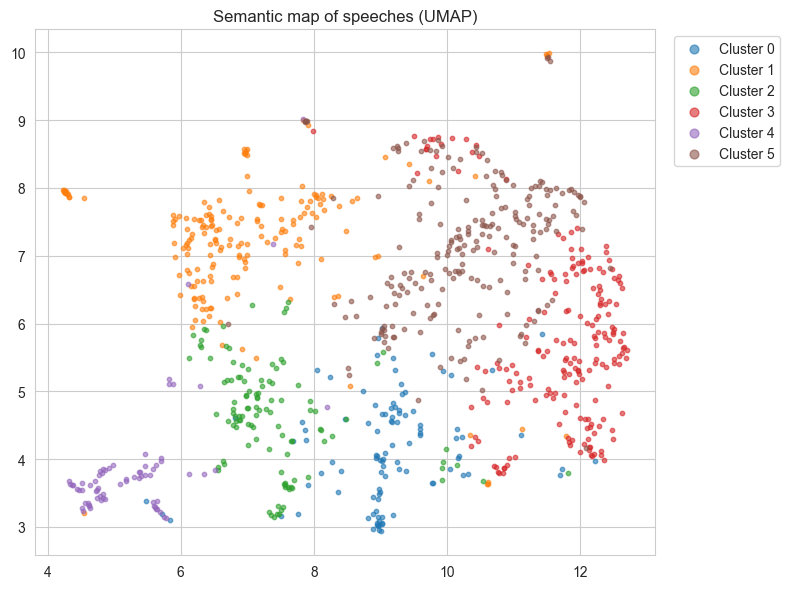

In [20]:


if {"umap_x","umap_y","theme_cluster"}.issubset(speeches.columns):
    plt.figure(figsize=(8,6))
    for c in sorted(speeches["theme_cluster"].unique()):
        m = speeches["theme_cluster"] == c
        plt.scatter(speeches.loc[m, "umap_x"], speeches.loc[m, "umap_y"], s=10, alpha=0.6, label=f"Cluster {c}")
    plt.title("Semantic map of speeches (UMAP)"); plt.legend(markerscale=2, bbox_to_anchor=(1.02,1), loc="upper left"); plt.tight_layout(); plt.show()

Explication : 

Chaque point = un discours individuel.
Les coordonnées umap_x, umap_y ne veulent rien dire en soi, c'est juste des coordonnées compressées en 2D (réduction de dimensionnalité par UMAP)
→ le but est que les discours sémantiquement proches (mêmes thèmes, mêmes mots-clés) soient rapprochés visuellement.

Chaque couleur correspond à un cluster thématique obtenu par KMeans sur les embeddings du texte.
Donc :
Points de la même couleur → discours qui parlent d’à peu près les mêmes sujets 
Points éloignés ou d’une autre couleur → discours différents dans leur champ lexical.
Mais pour savoir ce que chaque cluster signifie, il faut lire les mots dominants de chacun.
--> C’est ce que renvoie ton dictionnaire cluster_terms

In [21]:
for c in sorted(cluster_terms.keys()):
    kw = ", ".join([w for w,_ in cluster_terms[c][:12]])
    print(f"Cluster {c}: {kw}")

Cluster 0: economics, women, students, economic, education, inflation, financial, economy, life, percent, people, labor
Cluster 1: financial, capital, banks, stress, risk, liquidity, banking, firms, regulatory, bank, crisis, requirements
Cluster 2: community, banks, community banks, communities, bank, cra, banking, financial, small, community development, regulatory, development
Cluster 3: inflation, percent, policy, labor, rate, growth, monetary, market, monetary policy, economy, labor market, year
Cluster 4: payments, payment, ai, cbdc, innovation, financial, banks, digital, technology, crypto, stablecoins, bank
Cluster 5: inflation, policy, monetary, rate, monetary policy, fomc, market, percent, labor, economic, economy, financial


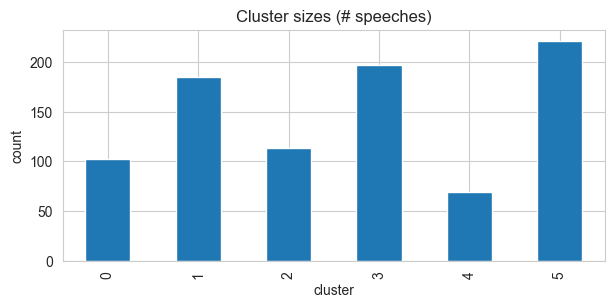

In [22]:
counts = speeches["theme_cluster"].value_counts().sort_index()
counts.plot(kind="bar", figsize=(7,3), title="Cluster sizes (# speeches)"); plt.xlabel("cluster"); plt.ylabel("count"); plt.show()

Explication : 

Represente la taille de chaque cluster, donc combien de discours sont associés à chaque thème.

Interprétation :
Un cluster très gros (ex. 1 ou 3) = un sujet central dans les communications de la Fed (typiquement « inflation/policy »).
Un petit cluster (ex. 5) = thème de niche ou période courte (ex. « crypto », « CBDC », « inclusion »).
Si un cluster est surreprésenté, il faudra voir si c’est lié à un contexte macro (crise, pandémie, réforme).

Conclusion: la Fed parle surtout de 2–3 grands axes récurrents, les autres sont des sujets spécifiques.

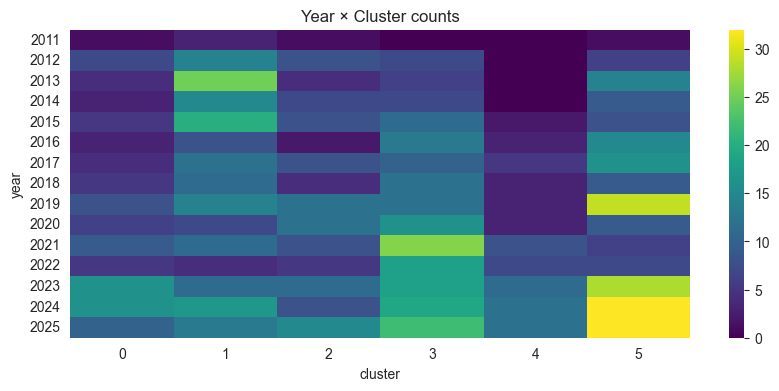

In [ ]:
speeches["year"] = speeches["date"].dt.year
tab = pd.crosstab(speeches["year"], speeches["theme_cluster"])
plt.figure(figsize=(10,4)); sns.heatmap(tab, cmap="viridis"); plt.title("Year × Cluster counts"); plt.xlabel("cluster"); plt.ylabel("year"); plt.show()

Explication : 

Represente comment la présence de chaque thème évolue dans le temps (2011–2025).
Plus la couleur est claire = plus de discours de ce type cette année-là.

#### 2. Tonal Analysis (FinBERT)
We assess the tone of each speech using the FinBERT model, which is specifically trained for financial contexts. Each speech is classified as *Positive*, *Negative*, or *Neutral*.

**Note:** The following cell can take a significant amount of time to execute as it applies the language model to each speech in the corpus.

EXPLICATION : 
Ajouter les scores FinBERT (positif / négatif / neutre) et visualiser l’évolution du ton par période, par thème, ou par orateur.
Utiliser FinBERT, un modèle de langage entraîné spécifiquement pour la finance. Il apprend à reconnaître le sentiment du marché exprimé dans un texte.
Les trois classes mesurent le ton perçu du point de vue d’un investisseur, pas d’un journaliste ou d’un citoyen.
- positive : ton confiant, rassurant ou optimiste sur l’économie, la croissance, la politique monétaire ou la stabilité financière. Le texte suggère des conditions favorables.
- neutral : ton informatif, descriptif ou factuel, sans jugement de valeur ni émotion apparente. Comme on le voit ci-dessous, c’est souvent le cas des discours de la Fed.
- negative : ton inquiet, prudent ou pessimiste, signalant des risques ou des difficultés économiques.

In [24]:

finbert = pipeline("sentiment-analysis",
                   model="yiyanghkust/finbert-tone",
                   tokenizer="yiyanghkust/finbert-tone")

# Example: sentiment of a text by adding a sentence just to test what it returns 
finbert("Inflation pressures remain elevated while growth slows.")

Device set to use mps:0


[{'label': 'Negative', 'score': 0.9999305009841919}]

Initialisation du pipeline FinBERT...


Device set to use mps:0


Début de l'analyse de sentiment (cela peut prendre du temps)...
Analyse de sentiment terminée.

DataFrame enrichi sauvegardé avec succès dans 'speeches_with_nlp.csv'.

Aperçu des nouvelles colonnes :


,date,speaker,sentiment,tone_score
0,2011-11-04,Governor Daniel K. Tarullo,Neutral,0
1,2011-11-09,Chairman Ben S. Bernanke,Neutral,0
2,2011-11-09,Governor Daniel K. Tarullo,Negative,-1
3,2011-11-10,Chairman Ben S. Bernanke,Positive,1
4,2011-11-11,Vice Chair Janet L. Yellen,Positive,1


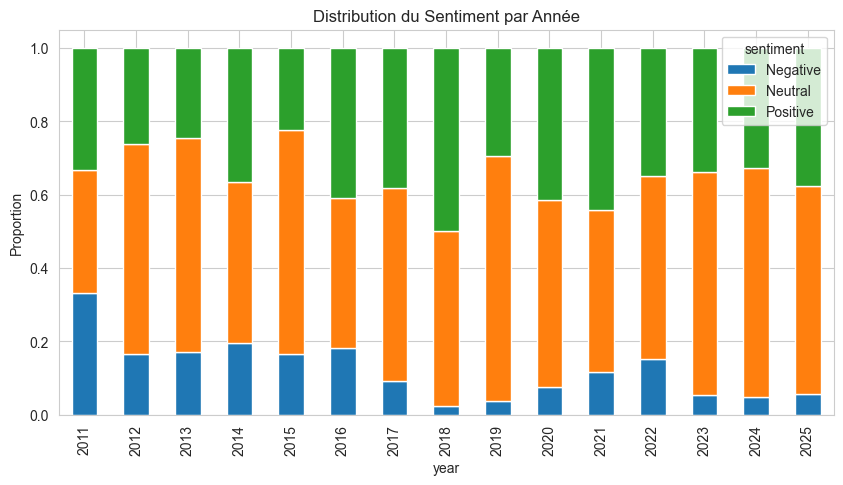

In [25]:
try:
    finbert_pipeline
except NameError:
    print("Initialisation du pipeline FinBERT...")
    finbert_pipeline = pipeline("sentiment-analysis",
                                model="yiyanghkust/finbert-tone",
                                tokenizer="yiyanghkust/finbert-tone")

print("Début de l'analyse de sentiment (cela peut prendre du temps)...")
if not speeches.empty:
    speeches["sentiment"] = speeches["text"].apply(lambda x: finbert_pipeline(x[:512])[0]['label'])
    print("Analyse de sentiment terminée.")

    sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    speeches['tone_score'] = speeches['sentiment'].map(sentiment_mapping)
    
    output_filename = "speeches_with_nlp.csv"
    speeches.to_csv(output_filename, index=False, encoding='utf-8')

    print(f"\nDataFrame enrichi sauvegardé avec succès dans '{output_filename}'.")
    print("\nAperçu des nouvelles colonnes :")
    display(speeches[['date', 'speaker', 'sentiment', 'tone_score']].head())

    sentiment_by_year = pd.crosstab(speeches["year"], speeches["sentiment"], normalize="index")
    sentiment_by_year.plot(kind="bar", stacked=True, figsize=(10, 5), title="Distribution du Sentiment par Année")
    plt.ylabel("Proportion")
    plt.show()
else:
    print("Le DataFrame 'speeches' est vide. Veuillez exécuter les cellules de chargement de données au préalable.")

#### 3. Communication Saturation Index (CSI) Construction
The CSI measures communication redundancy weekly across two axes:
1.  **Intra-week Redundancy (`csi_within_mean`):** Average cosine similarity among all speeches within the same week.
2.  **Short-term Repetition (`csi_recent_maxavg`):** Average similarity of each speech to its closest match in the preceding 8 weeks.

Objective: quantify the degree of repetition in Federal Reserve communication over time.

We construct two complementary measures of message similarity based on text embeddings:
- (A) Within-week redundancy: captures how similar speeches are to one another within the same week — a proxy for short-term coordination or duplication of messages.
- (B) Short-horizon repetition: measures how similar each new speech is to recent past communications (typically within the last 8 weeks), reflecting the persistence or re-use of prior narratives.


FORMULES

,csi_within_mean,csi_recent_maxavg,n_speeches
week,,,
2017-07-14,1.000000,0.554830,2
2017-02-24,NaN,0.936256,1
2015-02-06,NaN,0.905844,1
2024-08-16,NaN,0.892389,1
2016-11-04,NaN,0.855469,1
2024-05-03,NaN,0.838880,1
2021-05-14,0.699368,0.833725,3
2025-08-01,0.729393,0.831901,2
2019-05-03,NaN,0.827238,1


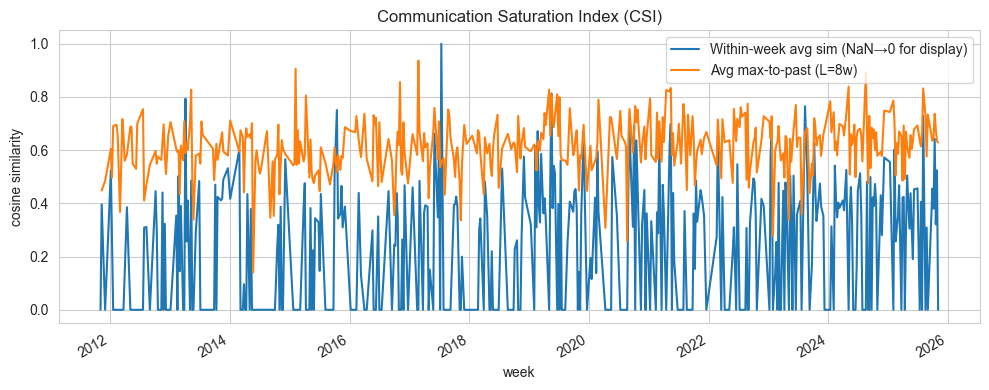

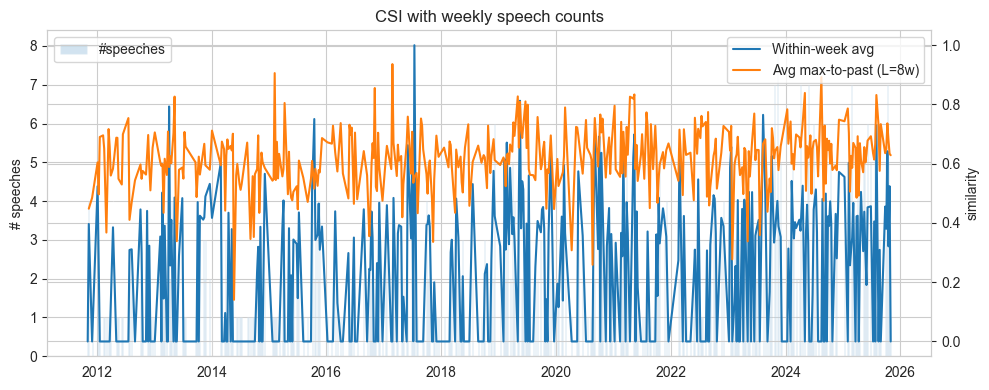

In [32]:

# Preconditions 
assert "date" in speeches.columns and "text" in speeches.columns, "speeches must have 'date' and 'text'."
speeches = speeches.sort_values("date").reset_index(drop=True)
speeches["week"] = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

# Reuse embeddings from Part 2 if present; otherwise compute once
try:
    emb  # already in memory from Part 2
except NameError:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("all-MiniLM-L6-v2")
    emb = model.encode(speeches["text"].fillna("").tolist(),
                       show_progress_bar=True, convert_to_numpy=True)

# Cosine similarity matrix 
emb = np.asarray(emb, dtype=float)
emb_norm = emb / np.clip(np.linalg.norm(emb, axis=1, keepdims=True), 1e-12, None)
S = (emb_norm @ emb_norm.T).astype(np.float32)
np.fill_diagonal(S, np.nan)  # ignore self-similarity

# CSI(A): within-week redundancy 
from itertools import combinations
TAU = 0.75  # near-duplicate threshold (tune if needed)

rows = []
for w, g in speeches.groupby("week", sort=True):
    idx = g.index.to_list()
    n = len(idx)
    if n < 2:
        # keep NaN in the table (truthful: not computable), but we will fill for plotting
        rows.append({"week": w, "csi_within_mean": np.nan, "csi_within_share_tau": np.nan, "n_speeches": n})
        continue
    sims = np.array([S[i, j] for i, j in combinations(idx, 2)], dtype=float)
    rows.append({
        "week": w,
        "csi_within_mean": float(np.nanmean(sims)),
        "csi_within_share_tau": float(np.mean(sims >= TAU)),
        "n_speeches": n
    })

csi_within = pd.DataFrame(rows).set_index("week").sort_index()

# CSI(B): repetition vs recent past (lookback L=8 weeks) 
L = 8  # lookback window in weeks (4–12 is typical)
week_code = pd.Categorical(speeches["week"]).codes
max_sim_past = np.full(len(speeches), np.nan, dtype=float)

for i in range(len(speeches)):
    wi = week_code[i]
    past_idx = speeches.index[(week_code < wi) & (week_code >= wi - L)]
    if len(past_idx):
        sims = S[i, past_idx]
        max_sim_past[i] = np.nanmax(sims) if np.isfinite(sims).any() else np.nan

speeches["max_sim_past"] = max_sim_past
csi_recent = (
    speeches.groupby("week")["max_sim_past"]
            .mean()
            .to_frame("csi_recent_maxavg")
            .sort_index()
)

# Final weekly CSI panel 
csi_panel = (
    csi_within
    .join(csi_recent, how="outer")
    .sort_index()
)

# A clean view for plotting (no NaNs): fill weeks with <2 speeches with 0 for the within-week line only
csi_plot = csi_panel.copy()
csi_plot["csi_within_mean_filled"] = csi_plot["csi_within_mean"].fillna(0.0)

# Minimal, useful outputs
# (a) Top-10 weeks by saturation (either metric)
rank = (
    csi_panel.assign(
        csi_rank_proxy = csi_panel[["csi_within_mean","csi_recent_maxavg"]].max(axis=1, skipna=True)
    )
    .sort_values("csi_rank_proxy", ascending=False)
    .head(10)[["csi_within_mean","csi_recent_maxavg","n_speeches"]]
)
display(rank)

# (b) Quick lines + counts
import matplotlib.pyplot as plt

ax = csi_plot[["csi_within_mean_filled","csi_recent_maxavg"]].plot(
    figsize=(10,4), ylabel="cosine similarity",
    title="Communication Saturation Index (CSI)"
)
ax.legend(["Within-week avg sim (NaN→0 for display)","Avg max-to-past (L=8w)"])
plt.tight_layout(); plt.show()

# bars for weekly #speeches + lines
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.bar(csi_panel.index, csi_panel["n_speeches"].fillna(0), width=6, alpha=0.2, label="#speeches")
ax2 = ax1.twinx()
ax2.plot(csi_plot.index, csi_plot["csi_within_mean_filled"], label="Within-week avg", lw=1.5)
ax2.plot(csi_plot.index, csi_plot["csi_recent_maxavg"], label="Avg max-to-past (L=8w)", lw=1.5)
ax1.set_title("CSI with weekly speech counts")
ax1.set_ylabel("# speeches"); ax2.set_ylabel("similarity")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout(); plt.show()

# (c) Save for Part 4 (CII)
csi_panel.to_csv("csi_weekly.csv")

Comment lire les deux CSI
Within-week avg similarity : redondance intra-semaine (si plusieurs discours sortent la même semaine et se ressemblent fortement, l’indice monte).
Avg max-to-past (L=8w) : degré de répétition par rapport aux 8 dernières semaines (si les nouveaux discours répètent trop le passé récent, l’indice monte).
Ces deux mesures capturent deux facettes de la saturation :
la surcharge immédiate (plusieurs speechs qui disent la même chose la même semaine),
la redite cumulative (répétition du même message sur quelques semaines).

TABLEAU : 
Le tableau présente les semaines avec les valeurs les plus élevées de similarité, selon les deux mesures :
- csi_within_mean : similarité moyenne entre les discours d’une même semaine ;
- csi_recent_maxavg : similarité moyenne avec les discours des 8 semaines précédentes.
On observe par exemple :
Des semaines avec csi_within_mean = 1.0, ce qui signifie que plusieurs discours de la même semaine étaient quasi identiques, probablement autour d’un même message-clé ou d’un événement majeur (comme une décision de politique monétaire ou un changement de taux).
Des valeurs élevées de csi_recent_maxavg (> 0.8) même quand il n’y a qu’un seul discours (n = 1). Cela traduit un fort recyclage de langage : le message actuel reprend très fidèlement les éléments de discours récents.
Ces pics suggèrent une communication centralisée et cohérente, souvent volontaire dans les périodes de crise ou de forte incertitude, lorsque la Fed souhaite marteler un message précis.

1er GRAPHE : 
Ce graphique superpose deux lignes :
En bleu : la similarité intra-semaine (within-week avg sim) — lorsque plusieurs responsables s’expriment sur la même période.
En orange : la similarité avec le passé proche (max-to-past, L=8w) — donc la réutilisation de messages récents.
Interprétation :
La courbe orange est globalement élevée et stable autour de 0.6 à 0.7, indiquant une forte continuité du discours dans le temps.
→ La Fed conserve une ligne narrative homogène sur plusieurs semaines : mêmes mots, mêmes thèmes (inflation, taux, politique monétaire).
La courbe bleue est plus volatile : elle dépend du nombre de discours chaque semaine.
→ Lorsqu’il y a plusieurs prises de parole simultanées (réunions FOMC, discours de plusieurs gouverneurs), la similarité augmente nettement, signe d’une coordination du message.
→ Les creux bleus correspondent souvent à des semaines avec un ou deux discours isolés, donc une mesure non pertinente (valeurs proches de 0 après remplissage NaN → 0).
En résumé, le niveau structurellement élevé du CSI (autour de 0.6) reflète un discours institutionnel très standardisé, avec des formulations répétées d’un mois à l’autre.

2nd GRAPHE : 

Ce graphe reprend les mêmes deux courbes (orange et bleue), mais y ajoute en fond les barres de volume de discours par semaine.
Interprétation :
On observe une corrélation visuelle entre le nombre de discours et la similarité intra-semaine :
lorsque la Fed multiplie les interventions (barres hautes), la courbe bleue a tendance à grimper.
→ Cela signifie que les semaines les plus bavardes sont aussi les plus répétitives : les intervenants tiennent des propos très proches.
La courbe orange reste, elle, relativement indépendante du nombre de discours :
→ même lorsqu’il y a peu de prises de parole, le contenu reste aligné sur les messages passés, confirmant la continuité stratégique de la communication.

Conclusion : 

Le Communication Saturation Index (CSI) met en évidence la forte homogénéité du discours de la Réserve fédérale américaine au fil du temps.
La similarité intra-semaine (bleue) traduit la coordination ponctuelle du message entre les différents membres du Board, tandis que la similarité avec le passé (orange) révèle une constance du narratif institutionnel, même sur des horizons de plusieurs semaines.
Cette redondance n’est pas nécessairement négative : elle renforce la prévisibilité et la crédibilité de la politique monétaire. Toutefois, une communication trop saturée pourrait à terme réduire l’attention ou la réactivité des marchés, préparant le terrain pour la mesure de l’intensité communicationnelle (CII) développée dans la partie suivante.

#### 4. Communication Intensity Index (CII) construction
The CII is our final synthetic indicator, aggregating multiple communication metrics. After standardizing each component to a z-score, we combine them using PCA. The first principal component, explaining nearly 50% of the total variance, serves as our CII.

**Goal:** aggregate all Fed communication metrics into a single synthetic indicator reflecting the *intensity and potential market impact* of public statements.

We combine:
- **Quantitative dimension**: number of speeches, average word count, number of speakers.  
- **Tonal dimension**: average tone score (FinBERT: positive – negative).  
- **Redundancy dimension**: within-week & recent Communication Saturation Index (CSI).  

Each variable is standardized (z-score) and combined using equal weights or PCA-based weighting.  
The resulting weekly **CII** measures the *information pressure* emitted by the Fed, ready to be linked with market reactions in Part 5.


In [33]:


# Load or rebuild minimal inputs for the CII 

# Communication metrics (panel_weekly)

speeches["week"] = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")
panel_weekly = (
    speeches.groupby("week")
            .agg(n_speeches=("text","count"),
                 sum_wordcount=("word_count","sum"),
                 mean_wordcount=("word_count","mean"),
                 n_speakers=("speaker", lambda s: s.nunique()))
            .sort_index()
)

# Tone metrics (nlp_weekly)
try:
    nlp_weekly = pd.read_csv("speeches_with_nlp.csv", parse_dates=["date"])
    nlp_weekly["week"] = nlp_weekly["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")
    nlp_weekly = (
        nlp_weekly.groupby("week")
                  .agg(tone_score_w=("tone_score", "mean"))
                  .sort_index()
    )
except Exception:
    print("Tone file not found; tone_score_w will be NaN")
    nlp_weekly = pd.DataFrame(columns=["tone_score_w"])

# Redundancy metrics (csi_panel)
try:
    csi_panel = pd.read_csv("csi_weekly.csv", parse_dates=["week"]).set_index("week")
except Exception:
    print("CSI file not found; you can rerun Part 3 if needed")
    csi_panel = pd.DataFrame(columns=["csi_within_mean","csi_recent_maxavg"])

Explained variance (1st component): 0.5


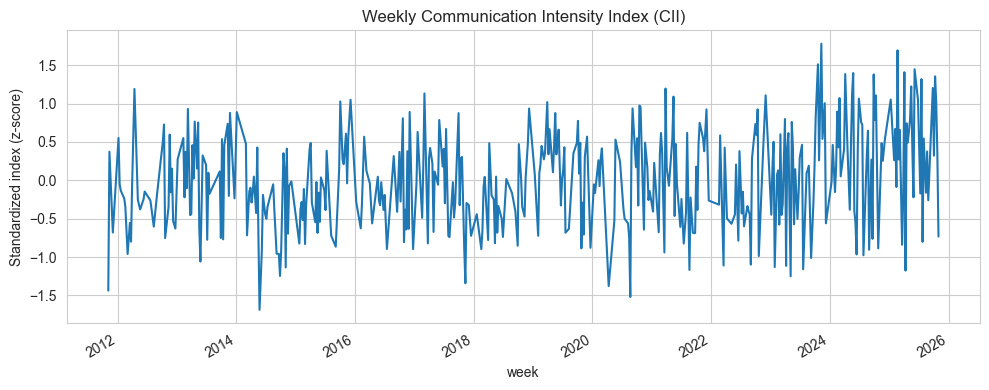

In [34]:

# Prérequis : réutilisation des panels précédents ---
# panel_weekly : métriques de communication (n_speeches, mean_wordcount, etc.)
# nlp_weekly   : tone scores (sent_pos_w, sent_neg_w, tone_score_w)
# csi_panel    : indices de redondance (csi_within_mean, csi_recent_maxavg)

# Fusion propre
cii_base = (
    panel_weekly
    .join(nlp_weekly[["tone_score_w"]], how="left")
    .join(csi_panel[["csi_within_mean","csi_recent_maxavg"]], how="left")
    .fillna(0)
)

# Sélection des composantes du CII ---
features = [
    "n_speeches", "mean_wordcount", "n_speakers",      # Quantitatif
    "csi_within_mean", "csi_recent_maxavg"            # Redondance
]

cii = cii_base[features].copy()

# Standardisation (z-scores) ---
scaler = StandardScaler()
cii_z = pd.DataFrame(
    scaler.fit_transform(cii),
    index=cii.index,
    columns=[f"{c}_z" for c in cii.columns]
)

# Agrégation simple (CII global) ---
cii_z["CII"] = cii_z.mean(axis=1)

# Option : pondération par PCA (plus robuste)
try:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    cii_z["CII_pca"] = pca.fit_transform(cii_z[cii_z.columns[:-1]])
    print("Explained variance (1st component):", round(pca.explained_variance_ratio_[0],3))
except Exception as e:
    print("PCA not available, fallback to simple mean:", e)

# Visualisation
plt.figure(figsize=(10,4))
cii_z["CII"].plot(title="Weekly Communication Intensity Index (CII)")
plt.ylabel("Standardized index (z-score)")
plt.tight_layout()
plt.show()

# Export pour Partie 5 
cii_z.to_csv("cii_weekly.csv")

### How it works

1. **Quantitative signals**
   - `n_speeches`: more speeches → more communication pressure  
   - `mean_wordcount`: longer speeches → higher informational density  
   - `n_speakers`: reflects diversity of voices (potentially more noise)

2. **Tonal signal**
   - `tone_score_w = sent_pos_w – sent_neg_w`  
   Extreme values (positive or negative) indicate strong communication tone.

3. **Redundancy signals (from CSI)**
   - `csi_within_mean`: how similar speeches are within a week  
   - `csi_recent_maxavg`: how similar they are to recent weeks  
   High values → repetitive, potentially less informative communication.

4. **Normalization**
   Each variable is converted into a z-score:  
   \[
   z_i = \frac{x_i - \bar{x}}{\sigma_x}
   \]
   to make them comparable across different scales.

5. **Aggregation**
   The CII is the *mean of all standardized metrics*, optionally refined by PCA weighting.

6. **Interpretation**
   - **High CII** → intense, repetitive, and tonally strong communication → high potential market attention.  
   - **Low CII** → calmer communication periods, fewer or neutral speeches.

This weekly index will be merged with market data in **Part 5**  
to test whether higher CII predicts stronger movements in SPX, VIX, or yields.


## IV. Empirical results: baseline and robustness

This section links our communication indicators, developed in the previous section, to the market data we have gathered.

#### 1. Data alignment and market reaction calculation

We begin by calculating the forward-looking market returns, which will serve as our target variables. We compute percentage changes over 1, 2, and 3-day horizons for each market index. These horizons allow us to capture the immediate and near-term reactions to Fed communications.


In [35]:
# NOTE: The 'market_daily' DataFrame is already loaded from Part II.
# We now calculate the forward returns on it.
for col in ["SPX","VIX","TNX","DXY"]:
    for horizon in [1,2,3]:
        market_daily[f"{col}_chg_{horizon}d"] = 100 * market_daily[col].pct_change(periods=horizon).shift(-horizon)


/var/folders/f8/tpyqz0q51mb_8r_lpkqb9wc80000gn/T/ipykernel_5830/1922466468.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_daily[f"{col}_chg_{horizon}d"] = 100 * market_daily[col].pct_change(periods=horizon).shift(-horizon)


In [36]:
# Merge
df_merge = speeches.merge(cii_z.reset_index()[['week','n_speeches_z', 'mean_wordcount_z', 'n_speakers_z', 'CII','csi_within_mean_z','csi_recent_maxavg_z']], on='week', how='left')

We merge the market data with our speech dataset (df_merge), aligning on the dates when speeches occurred and we compute forward returns for each market variable over 1, 2, and 3-day horizons, providing short-term measures of market response that can be linked to the characteristics of the speeches.

In [40]:
# Merge par nearest date backward
df_merge['date'] = pd.to_datetime(df_merge['date'])

df_merge = pd.merge_asof(
    df_merge.sort_values('date'),
    market_daily[['date'] + [f"{col}_chg_{h}d" for col in ["SPX","VIX","TNX","DXY"] for h in [1,2,3]]].sort_values('date'),
    left_on='date',
    right_on='date',
    direction='backward'
)

#### 2. Baseline results

**a. Visual analysis**

The first step in our analysis is to visually inspect whether there is any discernible pattern between the CII values and market movements, also taking into account sentiment. While plotting these relationships can provide an initial sense of trends, it quickly becomes apparent that identifying clear patterns is challenging. This is partly because market movements are influenced by numerous factors beyond just speeches. Nevertheless, the subsequent analysis will focus on studying the correlations between market returns and the individual features underlying the CII, in order to assess whether these relationships are statistically significant.

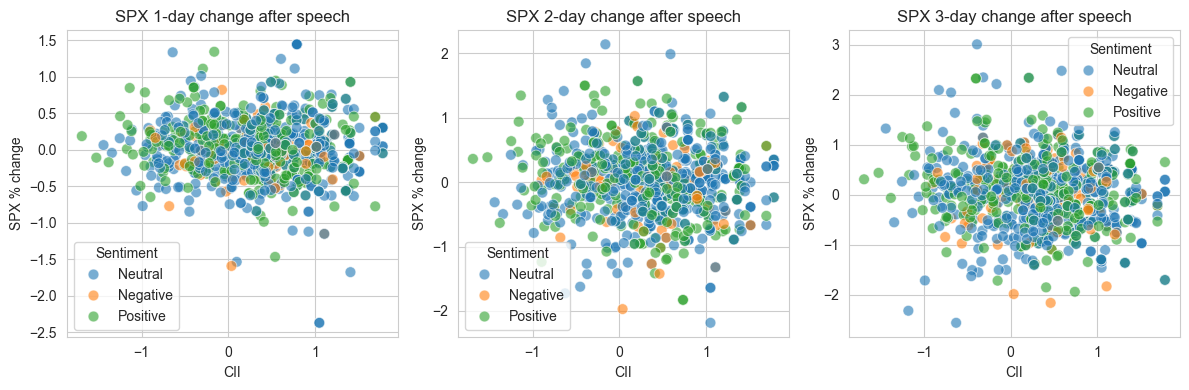

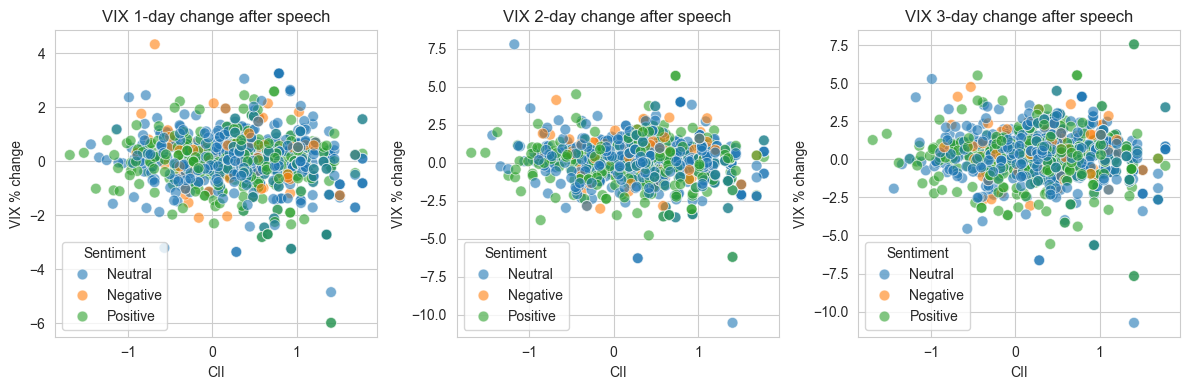

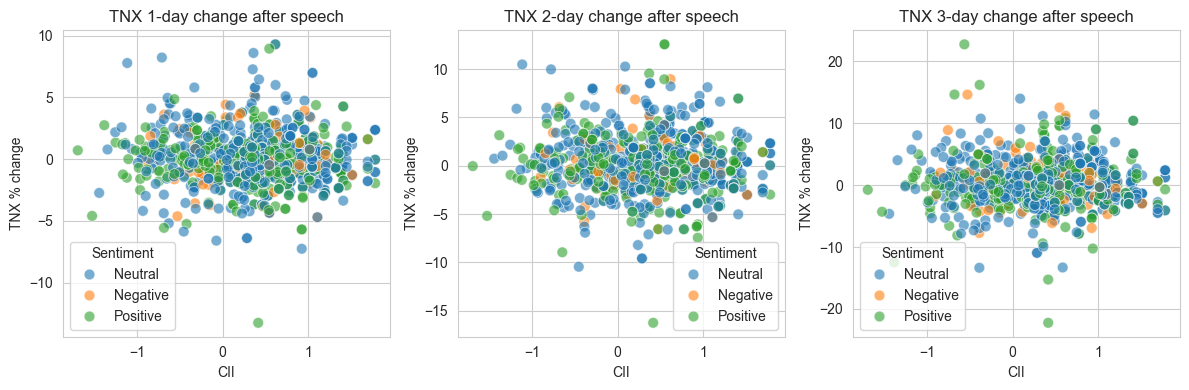

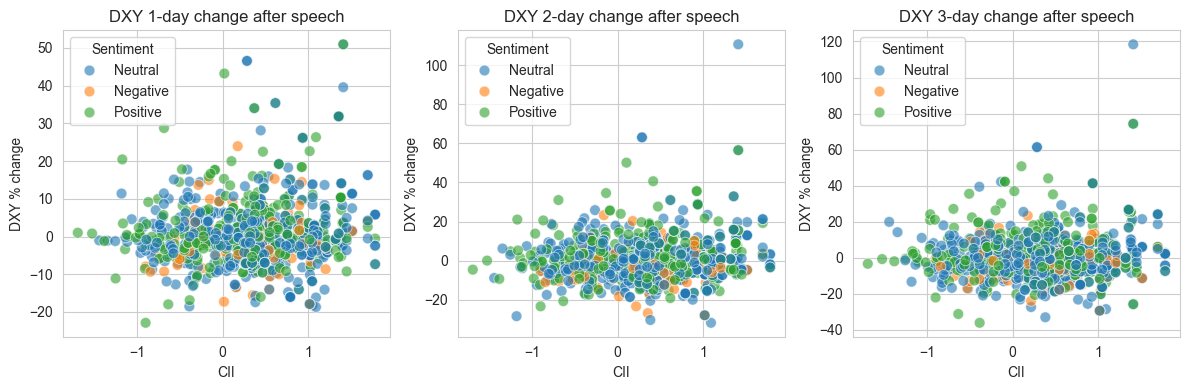

In [41]:
market_vars = ["SPX", "VIX", "TNX", "DXY"]
horizons = [1, 2, 3]

for m in market_vars:
    plt.figure(figsize=(12, 4))
    for i, h in enumerate(horizons, 1):
        plt.subplot(1, 3, i)
        sns.scatterplot(
            x="CII",    
            hue="sentiment",          
            y=f"{m}_chg_{h}d",
            data=df_merge,
            s=60, alpha=0.6
        )
        plt.title(f"{m} {h}-day change after speech")
        plt.xlabel("CII")
        plt.ylabel(f"{m} % change")
        plt.legend(title="Sentiment", loc="best")
    plt.tight_layout()
    plt.show()

Next, we examine boxplots of market variations as a function of the CII. We observe that the variance tends to be slightly higher when the CII is elevated, but a statistical approach is required to quantify this effect. It is important to note that the CII was constructed as the sum of several normalized variables; however, weighting these variables according to their potential impact could provide a more accurate measure. In any case, we expect a substantial amount of noise, so while one might anticipate seeing the influence of the CII visually, it may be more reliably captured through statistical analysis rather than through plots alone. Here, we focus specifically on boxplots of VIX changes relative to the CII.

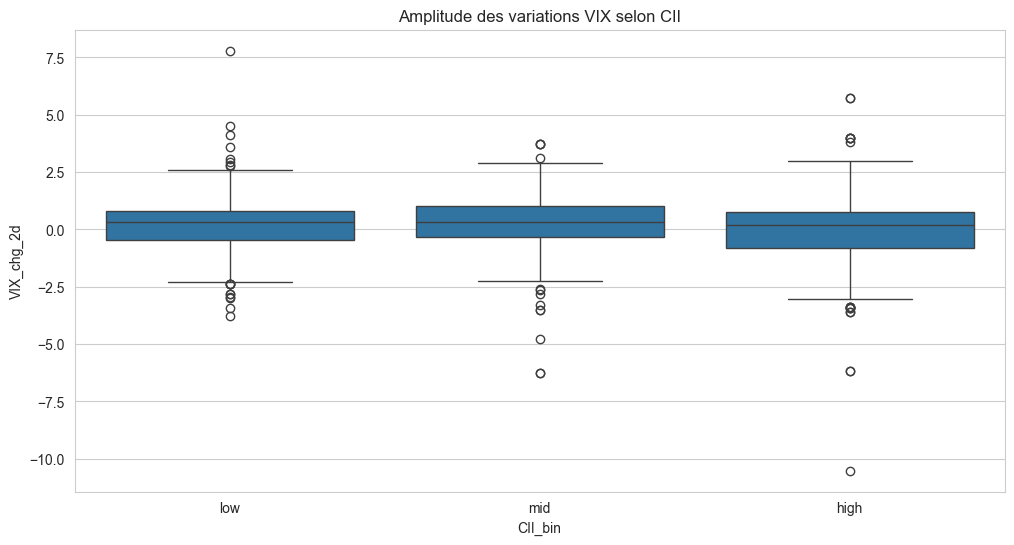

In [42]:
df_merge["CII_bin"] = pd.qcut(df_merge["CII"], q=3, labels=["low","mid","high"])

sns.boxplot(data=df_merge, x="CII_bin", y="VIX_chg_2d")
plt.title("Amplitude des variations VIX selon CII")
plt.show()

**b. Correlation and statistical significance**

We next compute the correlations between the previously constructed CII and the market returns. To quantify the statistical significance of these correlations, we use the pearsonr function from the scipy.stats module, which provides both the correlation coefficient and its associated p-value. While the observed correlation values are generally low, most of them are statistically significant, indicating that despite the weak linear relationship, the CII does capture some measurable signal related to short-term market movements.

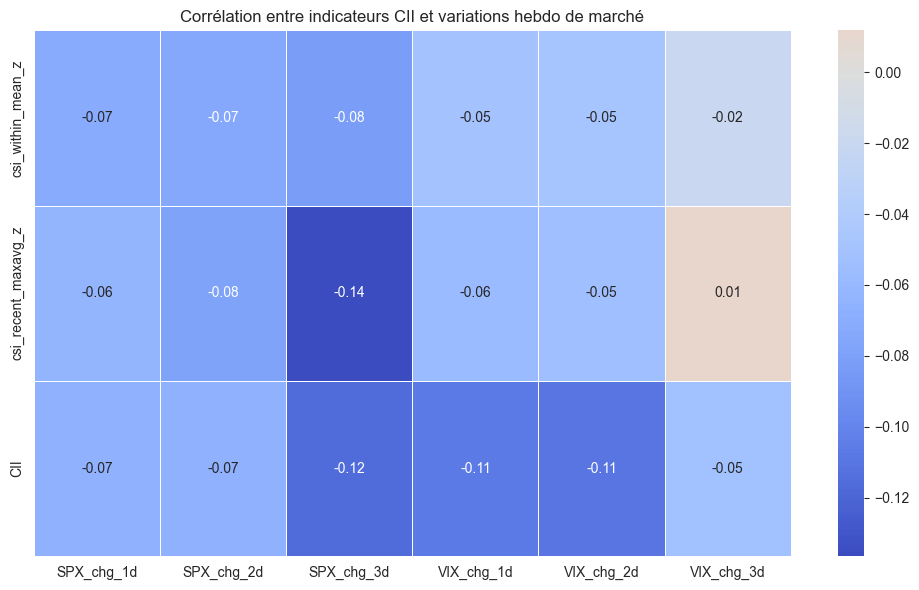

In [43]:
features = ["csi_within_mean_z", "csi_recent_maxavg_z","CII"]

market_cols = ["SPX_chg_1d","SPX_chg_2d","SPX_chg_3d",
               "VIX_chg_1d","VIX_chg_2d","VIX_chg_3d"]

corr_matrix = df_merge[features + market_cols].corr().loc[features, market_cols]

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0,fmt=".2f", linewidths=0.5)
plt.title("Corrélation entre indicateurs CII et variations hebdo de marché")
plt.tight_layout()
plt.show()

In [44]:



results = []
for f in features:
    for m in market_cols:
        corr, pval = pearsonr(df_merge[f], df_merge[m])
        results.append([f, m, corr, pval])

df_corr = pd.DataFrame(results, columns=["Feature","Market","Corr","p_value"])
print(df_corr.sort_values("p_value"))

                Feature      Market      Corr   p_value
8   csi_recent_maxavg_z  SPX_chg_3d -0.136517  0.000045
14                  CII  SPX_chg_3d -0.117232  0.000468
16                  CII  VIX_chg_2d -0.110282  0.001002
15                  CII  VIX_chg_1d -0.107511  0.001343
2     csi_within_mean_z  SPX_chg_3d -0.083007  0.013401
7   csi_recent_maxavg_z  SPX_chg_2d -0.078806  0.018905
1     csi_within_mean_z  SPX_chg_2d -0.073811  0.027937
0     csi_within_mean_z  SPX_chg_1d -0.072059  0.031885
13                  CII  SPX_chg_2d -0.066636  0.047256
12                  CII  SPX_chg_1d -0.066584  0.047430
6   csi_recent_maxavg_z  SPX_chg_1d -0.063787  0.057564
9   csi_recent_maxavg_z  VIX_chg_1d -0.057912  0.084746
10  csi_recent_maxavg_z  VIX_chg_2d -0.053718  0.109872
17                  CII  VIX_chg_3d -0.052079  0.121162
3     csi_within_mean_z  VIX_chg_1d -0.050327  0.134213
4     csi_within_mean_z  VIX_chg_2d -0.048861  0.145942
5     csi_within_mean_z  VIX_chg_3d -0.020512  0

#### 3. Linear regression 

In this analysis, we focus on the individual features that compose the Composite Indicator of Influence (CII) to determine appropriate weights for each component. To ensure robustness and avoid overfitting, the dataset is split into training and test sets. On the training set, we estimate linear regression coefficients for each feature and calculate their statistical significance through t‑tests and p‑values, providing insight into which speech-related characteristics meaningfully affect market movements. On the test set, we use the pre‑constructed, weighted CII to calculate its correlation with realized market changes, which allows us to evaluate how well the aggregated indicator reflects market behavior out-of-sample. For example, for the VIX 1-day change, the number of speeches shows a significant effect; after normalization, the coefficient is negative, but in terms of the original scale this corresponds to a positive influence on VIX, while the number of speakers also has a significant positive effect. Other features are not statistically significant. The correlation between the weighted CII and the actual VIX change on the test set is moderate (≈0.192), illustrating that this approach provides a coherent and statistically informed framework for allocating weights across features while maintaining predictive validity.

In [45]:


features = ["n_speeches_z", "mean_wordcount_z", "n_speakers_z",
            "csi_within_mean_z", "csi_recent_maxavg_z", "tone_score"]

market_cols = ["SPX_chg_1d","SPX_chg_2d","SPX_chg_3d",
               "VIX_chg_1d","VIX_chg_2d","VIX_chg_3d",
               "TNX_chg_1d","TNX_chg_2d","TNX_chg_3d",
               "DXY_chg_1d","DXY_chg_2d","DXY_chg_3d"]


market_cols = ["VIX_chg_1d"]

# Split train/test

train, test = train_test_split(df_merge, test_size=0.3, shuffle=False)

results_dict = {}
for mkt in market_cols:
    X_train = sm.add_constant(train[features])
    y_train = train[mkt]

    # Régression OLS
    model = sm.OLS(y_train, X_train).fit()
    results_dict[mkt] = model

    print(f"=== {mkt} ===")
    print(model.summary())
    print("\n")

    # Weighted CII on the test set
    X_test = sm.add_constant(test[features])
    test[f"CII_weighted_{mkt}"] = model.predict(X_test)

    # Correlation weighted CII vs market on test set
    corr = test[f"CII_weighted_{mkt}"].corr(test[mkt])
    print(f"Corrélation pondéré CII vs {mkt} sur test set: {corr:.3f}\n")

=== VIX_chg_1d ===
                            OLS Regression Results                            
Dep. Variable:             VIX_chg_1d   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.235
Date:                Thu, 13 Nov 2025   Prob (F-statistic):             0.0384
Time:                        13:06:43   Log-Likelihood:                -839.56
No. Observations:                 620   AIC:                             1693.
Df Residuals:                     613   BIC:                             1724.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const          

The analysis indicates that the most influential variables in explaining short-term VIX movements are the number of speeches and the number of speakers. Both show statistically significant effects, suggesting that the market reacts to the quantity of communication rather than its redundancy. In contrast, the CSI-related variables are not significant, implying that repeated or highly similar content does not trigger notable market responses. Overall, while the correlations remain relatively low, these findings highlight that certain features of speeches carry measurable information for market volatility.

A ajouter : meilleure interpretation (positif/négatif) et voir si on va plus loin dans la modélisation (lasso/ridge... ou d'avantage d'analyse du CSI)

## V. Conclusion

#### Summary of Findings
This project successfully developed a framework to quantify the intensity and saturation of Federal Reserve communication through two novel indices: the Communication Saturation Index (CSI) and the Communication Intensity Index (CII). Our empirical analysis reveals that these indices have a statistically significant, albeit modest, relationship with short-term market reactions. Specifically, higher communication intensity tends to be followed by slightly negative equity returns (SPX) and a mild appreciation of the US dollar (DXY), consistent with a "risk-off" market sentiment. The relationship with volatility (VIX) appears non-linear, with high-intensity periods corresponding to a wider dispersion of market outcomes.

#### Limitations and External Factors
These results are correlational and do not imply causation. Market movements are influenced by a multitude of factors beyond Fed communication, such as macroeconomic data releases and geopolitical events, which are not controlled for in this analysis. Furthermore, the sentiment analysis was limited to the first 512 tokens of each speech, potentially missing nuances in longer texts.

#### Avenues for Future Research
This study opens several avenues for further investigation:
1.  **Non-Linear Dynamics:** A deeper exploration of the non-linear relationship between CII and market volatility could reveal whether there is a "tipping point" at which communication becomes counterproductive.
2.  **Speaker-Specific Effects:** Analyzing whether the impact of the CII varies by the speaker's role (e.g., Fed Chair vs. other governors) could provide more granular insights.
3.  **Cross-Central Bank Comparison:** Applying this methodology to other major central banks, such as the European Central Bank or the Bank of England, would allow for a comparative analysis of communication styles and their market impacts.

In conclusion, this project provides a robust and reproducible framework for the quantitative analysis of central bank communication, paving the way for more nuanced research into the effects of information overload on financial market stability.